# ***CONNECTING TO GOOGLE DRIVE***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***LIBRARIES***

In [ ]:
import torch
import os
import torch.nn as nn
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import torch.nn.functional as Func
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
from tqdm import tqdm
from scipy.stats import norm
from scipy.optimize import minimize

np.random.seed(123)
#torch.manual_seed(123)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# **MODEL**

In [ ]:
# Define the WaveAct activation function
class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__()
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return torch.nn.functional.softplus(x) + 0.005*torch.sin(x)

# Define the FeedForward module
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=200):
        super(FeedForward, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        )

    def forward(self, x):
        return self.linear(x)

# Define the EncoderLayer module
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()

    def forward(self, x):
        x2 = self.act1(x)
        x = x + self.attn(x2, x2, x2)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x

# Define the DecoderLayer module
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()

    def forward(self, x, e_outputs):
        x2 = self.act1(x)
        x = x + self.attn(x2, e_outputs, e_outputs)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x

# Define the Encoder module
class Encoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Encoder, self).__init__()
        self.N = N
        # Manually define N encoder layers
        self.layers = nn.ModuleList([EncoderLayer(d_model, heads) for _ in range(N)])
        self.act = WaveAct()

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.act(x)

# Define the Decoder module
class Decoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Decoder, self).__init__()
        self.N = N
        # Manually define N decoder layers
        self.layers = nn.ModuleList([DecoderLayer(d_model, heads) for _ in range(N)])
        self.act = WaveAct()

    def forward(self, x, e_outputs):
        for layer in self.layers:
            x = layer(x, e_outputs)
        return self.act(x)

# Define the PINNsformer model
class PINNsformer(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads):
        super(PINNsformer, self).__init__()
        self.linear_emb = nn.Linear(3, d_model)  # Input dimension is 3 (S, sigma, t)
        self.encoder = Encoder(d_model, N, heads)
        self.decoder = Decoder(d_model, N, heads)
        self.linear_out = nn.Sequential(
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_out)
        )

    def forward(self, x):
        src = self.linear_emb(x)
        e_outputs = self.encoder(src)
        d_output = self.decoder(src, e_outputs)
        output = self.linear_out(d_output)
        return output

# ***RANDOM DATASET GENERATION FOR PDE AND OTHER CONDITIONS***

Total points: 2190
Interior: 365 points (S∈[0.1, 149.9])
S=0 boundary: 365 points (σ∈[0.0, 0.5])
σ=0 boundary: 365 points (S∈[0.2, 147.5])


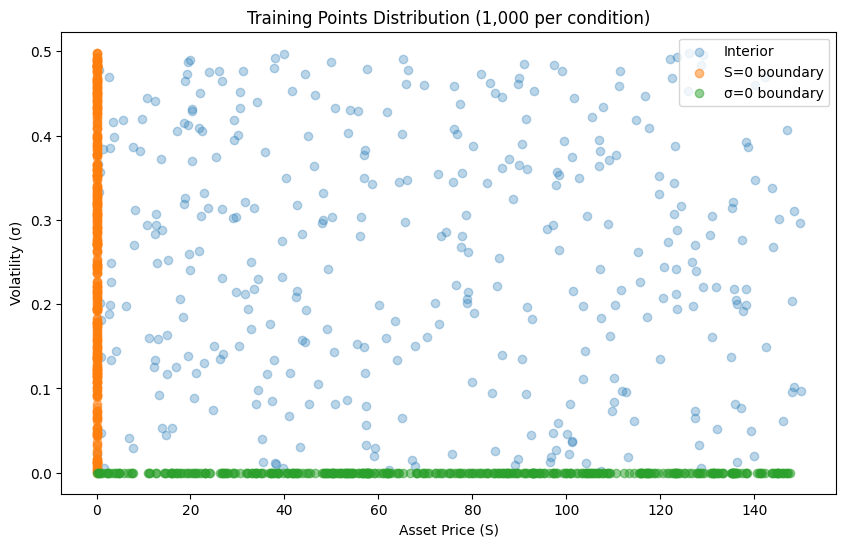

In [ ]:
def generate_points_per_condition(N=1000, S_min=0.0, S_max=150.0,
                                sigma_min=0.0, sigma_max=0.5, t=1.0):
    """
    Generates 1,000 random points for each:
    - Interior domain
    - S=0 boundary
    - S=S_max boundary
    - σ=0 boundary
    - σ=σ_max boundary
    - Initial condition (t=T)
    """
    # --- Interior points (S, σ, t all random) ---
    S_int = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigma_int = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_int = torch.rand(N, 1) * t
    interior = torch.cat([S_int, sigma_int, t_int], dim=1)

    # --- Boundary: S=0 (σ and t random) ---
    S0 = torch.zeros(N, 1)
    sigma_S0 = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_S0 = torch.rand(N, 1) * t
    bd_S0 = torch.cat([S0, sigma_S0, t_S0], dim=1)

    # --- Boundary: S=S_max (σ and t random) ---
    Smax = torch.ones(N, 1) * S_max
    sigma_Smax = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_Smax = torch.rand(N, 1) * t
    bd_Smax = torch.cat([Smax, sigma_Smax, t_Smax], dim=1)

    # --- Boundary: σ=0 (S and t random) ---
    S_sigma0 = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigma0 = torch.zeros(N, 1)
    t_sigma0 = torch.rand(N, 1) * t
    bd_sigma0 = torch.cat([S_sigma0, sigma0, t_sigma0], dim=1)

    # --- Boundary: σ=σ_max (S and t random) ---
    S_sigmamax = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigmamax = torch.ones(N, 1) * sigma_max
    t_sigmamax = torch.rand(N, 1) * t
    bd_sigmamax = torch.cat([S_sigmamax, sigmamax, t_sigmamax], dim=1)

    # --- Initial condition: t=T (S and σ random) ---
    S_initial = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigma_initial = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_initial = torch.zeros(N, 1)
    initial = torch.cat([S_initial, sigma_initial, t_initial], dim=1)

    # Combine all (total points = 6*N)
    all_points = torch.cat([
        interior, bd_S0, bd_Smax, bd_sigma0, bd_sigmamax, initial
    ], dim=0).requires_grad_(True)

    return {
        'interior': interior,
        'bd_S0': bd_S0,
        'bd_Smax': bd_Smax,
        'bd_sigma0': bd_sigma0,
        'bd_sigmamax': bd_sigmamax,
        'initial': initial,
        'all': all_points
    }

# Generate 1,000 points per condition
data = generate_points_per_condition(N=365)

# Verify
print(f"Total points: {len(data['all'])}")
print(f"Interior: {len(data['interior'])} points (S∈[{data['interior'][:,0].min():.1f}, {data['interior'][:,0].max():.1f}])")
print(f"S=0 boundary: {len(data['bd_S0'])} points (σ∈[{data['bd_S0'][:,1].min():.1f}, {data['bd_S0'][:,1].max():.1f}])")
print(f"σ=0 boundary: {len(data['bd_sigma0'])} points (S∈[{data['bd_sigma0'][:,0].min():.1f}, {data['bd_sigma0'][:,0].max():.1f}])")

# Plot S-σ distribution
plt.figure(figsize=(10, 6))
plt.scatter(data['interior'][:,0], data['interior'][:,1], label='Interior', alpha=0.3)
plt.scatter(data['bd_S0'][:,0], data['bd_S0'][:,1], label='S=0 boundary', alpha=0.5)
plt.scatter(data['bd_sigma0'][:,0], data['bd_sigma0'][:,1], label='σ=0 boundary', alpha=0.5)
plt.xlabel("Asset Price (S)"), plt.ylabel("Volatility (σ)")
plt.title("Training Points Distribution (1,000 per condition)")
plt.legend()
plt.show()

In [ ]:
class EarlyStopping:
    def __init__(self, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, loss):
        if self.best_loss is None:
            self.best_loss = loss
        elif loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = loss
            self.counter = 0

# ***ANALYTICAL BS - MONTE CARLO***

In [ ]:
# ANALYTICAL BS OPTION PRICE

def black_scholes_option_price(S, K, T, r, sigma, option_type='call'):

    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T+0.00000001))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        # Calculate the price of a European call option
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        # Calculate the price of a European put option
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    return option_price

# MONTE CARLO OPTION PRICE

def sabr_european_call_mc(S0_array, sigma0_array, T_array, K, r,
                          beta, nu, rho, N, M, confidence=0.95):

    S0_array = np.asarray(S0_array).flatten()
    sigma0_array = np.asarray(sigma0_array).flatten()
    T_array = np.asarray(T_array).flatten()

    n_samples = len(S0_array)
    prices = np.zeros(n_samples)
    conf_intervals = []

    z_score = norm.ppf(1 - (1 - confidence) / 2)

    for i in range(n_samples):
        S0 = S0_array[i]
        alpha0 = sigma0_array[i]
        T = T_array[i]
        dt = T / N
        sqrt_dt = np.sqrt(dt)

        # Initialize arrays
        S = np.zeros((M, N+1))
        alpha = np.zeros((M, N+1))
        S[:, 0] = S0
        alpha[:, 0] = alpha0

        for t in range(N):
            z1 = np.random.randn(M)
            z2 = np.random.randn(M)
            dW1 = z1
            dW2 = rho * z1 + np.sqrt(1 - rho**2) * z2

            alpha[:, t+1] = alpha[:, t] + nu * alpha[:, t] * dW2 * sqrt_dt
            S[:, t] = np.maximum(S[:, t], 1e-12)
            sigma_S = alpha[:, t] * (S[:, t]**(beta))
            mu_S = r * S[:, t]
            S[:, t+1] = S[:, t] + mu_S * dt + sigma_S * dW1 * sqrt_dt
            #S[:, t+1] = S[:, t]  + sigma_S * dW1 * sqrt_dt

        # Call option payoff
        payoffs = np.maximum(S[:, -1] - K, 0)
        discounted = np.exp(-r * T) * payoffs

        mean_price = np.mean(discounted)
        prices[i] = mean_price

    return prices


# ***PDE AND PINN CONDITIONS***

In [ ]:
# Define a function to compute the partial derivatives needed for the SABR PDE
def compute_derivatives(model, S, sigma, t):
    inputs = torch.cat([S, sigma, t], dim=1).to(device)
    # Compute C (option price)
    C = model(inputs)

    # Compute partial derivatives using autograd
    C_S = torch.autograd.grad(C, S, grad_outputs=torch.ones_like(C), create_graph=True)[0]
    C_sigma = torch.autograd.grad(C, sigma, grad_outputs=torch.ones_like(C), create_graph=True)[0]
    C_t = torch.autograd.grad(C, t, grad_outputs=torch.ones_like(C), create_graph=True)[0]

    C_SS = torch.autograd.grad(C_S, S, grad_outputs=torch.ones_like(C_S), create_graph=True)[0]
    C_sigmasigma = torch.autograd.grad(C_sigma, sigma, grad_outputs=torch.ones_like(C_sigma), create_graph=True)[0]
    C_Ssigma = torch.autograd.grad(C_S, sigma, grad_outputs=torch.ones_like(C_S), create_graph=True)[0]

    return C, C_S, C_sigma, C_t, C_SS, C_Ssigma, C_sigmasigma

    # Define the SABR PDE
def sabr_pde(model, S, sigma, t, beta, nu, rho, r):
    device = S.device
    # Ensure parameters are on the same device
    beta = torch.tensor(beta, dtype=torch.float32, device=device)
    nu = torch.tensor(nu, dtype=torch.float32, device=device)
    rho = torch.tensor(rho, dtype=torch.float32, device=device)
    r = torch.tensor(r, dtype=torch.float32, device=device)

    C, C_S, C_sigma, C_t, C_SS, C_Ssigma, C_sigmasigma = compute_derivatives(model, S, sigma, t)

    # Compute the terms of the SABR PDE
    term1 = C_t
    term2 = 0.5 * sigma**2 * S**(2*beta) * C_SS
    term3 = rho * nu * (sigma**2) * S**beta * C_Ssigma
    term4 = 0.5 * nu**2 * (sigma**2) * C_sigmasigma
    term5 = r * S * C_S
    term6 = -r * C

    # SABR PDE that equal to zero
    residual = term1 + term2 + term3 + term4 + term5 + term6
    return residual

def IC_european_call(S, K):
    val = torch.maximum(S - K, torch.tensor(0.0)).to(device)
    return val.view(-1, 1).requires_grad_(True)

# Define boundary conditions
def Smin_conditions(model, inputs_S_min):
    # Boundary condition for S = S_min
    boundary_S_min = model(inputs_S_min)  # V(t, F_min, alpha) = 0
    boundary_S_min = torch.mean(boundary_S_min**2)

    return boundary_S_min

# Define boundary conditions
def Smax_conditions2(model,  inputs_S_max):
    # Boundary condition for S = S_max
    fSmax = inputs_S_max[:, 0].requires_grad_(True).reshape(-1, 1).to(device)
    V_S_max = model(inputs_S_max)
    V_S_max_dx = torch.autograd.grad(V_S_max, inputs_S_max, torch.ones_like(V_S_max), create_graph=True)[0]
    dVdS = V_S_max_dx[:, 0].reshape(-1, 1)
    boundary_S_max = dVdS - 1
    boundary_S_max = torch.mean(boundary_S_max**2)
    return boundary_S_max

    # Define boundary conditions
def Smax_conditions(model,  inputs_S_max):
    # Boundary condition for S = S_max
    fSmax = inputs_S_max[:, 0].requires_grad_(True).reshape(-1, 1).to(device)
    V_S_max = model(inputs_S_max)
    V_S_max_dx = torch.autograd.grad(V_S_max, inputs_S_max, torch.ones_like(V_S_max), create_graph=True)[0]
    V_S_max_d2x = torch.autograd.grad(V_S_max_dx, inputs_S_max, torch.ones_like(V_S_max_dx), create_graph=True)[0]
    dSmaxd2x = V_S_max_d2x[:, 0].reshape(-1, 1)
    boundary_S_max = torch.mean(dSmaxd2x**2)
    return boundary_S_max

# Define boundary conditions
def v0_conditions(model, inputs_v_min, K, r):
    # Boundary condition for alpha = 0
    Vmin_S = inputs_v_min[:, 0].reshape(-1, 1).to(device)
    Vmin_t = inputs_v_min[:, 2].reshape(-1, 1).to(device)
    V_v_min = model(inputs_v_min)
    V_v_min_dt = torch.autograd.grad(V_v_min, inputs_v_min, torch.ones_like(V_v_min), create_graph=True)[0]
    dVmindt = V_v_min_dt[:, 2].reshape(-1, 1)
    #boundary_alpha_min = V_alpha_min_dt
    boundary_v_min = V_v_min - torch.maximum(Vmin_S - K*torch.exp(-r*Vmin_t), torch.tensor(0.0))
    boundary_v_min = torch.mean(boundary_v_min**2)

    return boundary_v_min

# Define boundary conditions
def Vmax_conditions(model, inputs_v_max, beta):
    Vmax_S = inputs_v_max[:, 0].reshape(-1, 1).to(device)
    Vmax = inputs_v_max[:, 1].reshape(-1, 1).to(device)
    Vmax_t = inputs_v_max[:, 2].reshape(-1, 1).to(device)

    # Boundary condition for alpha = alpha_max
    V_v_max = model(inputs_v_max)

    V_v_max_dt = torch.autograd.grad(V_v_max, inputs_v_max, torch.ones_like(V_v_max), create_graph=True)[0]
    dVmaxdt = V_v_max_dt[:, 2].reshape(-1, 1)

    V_v_max_dx = torch.autograd.grad(V_v_max, inputs_v_max,  torch.ones_like(V_v_max), create_graph=True)[0]
    dVmaxdx = V_v_max_dx[:, 0].reshape(-1, 1)

    V_v_max_d2x = torch.autograd.grad(V_v_max_dx, inputs_v_max, torch.ones_like(V_v_max_dx), create_graph=True)[0]
    dVmaxd2x = V_v_max_d2x[:, 0].reshape(-1, 1)

    boundary_v_max = dVmaxdt + 0.5 * Vmax**2 * (Vmax_S**(2*beta)) * dVmaxd2x
    boundary_v_max = torch.mean(boundary_v_max**2)

    return boundary_v_max


# ***CALIBRATION***

In [ ]:
def sabr_volatility(alpha, beta, rho, nu, F, K, T):
    """ Computes the SABR model implied volatility using Hagan's formula """
    if F == K:  # ATM case
        FK_beta = F**(1 - beta)
        vol = alpha / FK_beta * (1 + (((1 - beta) ** 2) / 24 * (alpha**2 / FK_beta**2) +
                                     (1 / 4) * (rho * beta * nu * alpha / FK_beta) +
                                     ((2 - 3 * rho**2) / 24) * (nu**2)) * T)
    else:
        z = (nu / alpha) * (F * K) ** ((1 - beta) / 2) * np.log(F / K)
        x_z = np.log((np.sqrt(1 - 2 * rho * z + z**2) + z - rho) / (1 - rho))
        FK_beta = (F * K) ** ((1 - beta) / 2)
        term1 = (1 + ((((1-beta)**2)/24)*((alpha**2)/FK_beta**2) +
                     (1 / (4*FK_beta)) * (rho * beta * nu * alpha) +
                     ((2 - 3 * rho**2) / 24) * (nu**2)) * T)
        term2 = (1 + ((((1 - beta) ** 2) / 24) * ((np.log(F/K)) ** 2)) +
                 ((((1 - beta) ** 4) / 1920) * ((np.log(F/K)) ** 4)))
        vol = (alpha / FK_beta) * (z / x_z) * term1 / term2
    return vol

# Loss function to minimize
def sabr_loss(params, F, strikes, T, market_vols):
    alpha, beta, rho, nu = params
    model_vols = np.array([sabr_volatility(alpha, beta, rho, nu, F, K, T) for K in strikes])
    return np.sum((model_vols - market_vols) ** 2)

# ***CALLING REAL DATASET***

In [ ]:
# Load all sheets in the Excel file
excel_file = "/content/drive/MyDrive/Bitirme_real_dataset/european_options.xlsx"
sheet_names = pd.ExcelFile(excel_file).sheet_names

results_MC_df = pd.DataFrame(columns=["Sheet", "SABR Model MSE", "SABR Model MAPE"])

prediction_df = pd.DataFrame()

output_dir = "/content/drive/MyDrive/Bitirme_real_dataset/new/euro/SABRFormer"
os.makedirs(output_dir, exist_ok=True)

# ***TRAINING***

In [ ]:
#start = time.time()
for sheet_name in sheet_names:
    print(f"Processing sheet: {sheet_name}")
    # Load data for the current sheet
    df = pd.read_excel(excel_file, sheet_name=sheet_name)

    F = df['close'].values  # SPOT PRICE
    spot_price = df['close'].iloc[0]
    sigma = df['implied_volatility'].values
    K = df['strike'].values
    market_prices = df['Option_mid'].values
    time = df['Remaining_day'].values / 252

    # Initial guess for SABR parameters
    initial_guess = [sigma[0], 1, 0.0, 0.3]

        # Optimize SABR parameters
    result_parameters = minimize(sabr_loss, initial_guess, args=(F[0], K, time[0], sigma),
                              bounds=[(0.01, 1), (0, 1), (-0.99, 0.99), (0.01, None)])

    alfa, beta, rho, nu = result_parameters.x

    print("Optimized SABR parameters:")
    print("Alpha:", alfa)
    print("Beta:", beta)
    print("Rho:", rho)
    print("Nu:", nu)

    F_torch = torch.tensor(F, dtype=torch.float32, requires_grad=True).view(-1, 1)
    sigma_torch = torch.tensor(sigma, dtype=torch.float32, requires_grad=True).view(-1, 1)

    F_min, F_max = torch.min(F_torch).item(), torch.max(F_torch).item()
    v_min, v_max = torch.min(sigma_torch).item(), torch.max(sigma_torch).item()

    r=0.0007

    lambda1, lambda2 = 1, 1

    model = PINNsformer(d_out=1, d_model=4, d_hidden=512, N=1, heads=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=2e-5)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=200,
        min_lr=2e-5)    # Early stopping parameters

    early_stopping = EarlyStopping(patience=500, min_delta=1e-4)

    best_loss = float('inf')
    save_path = 'best_model.pth'

    totallosses=[]
    Lic_list = []
    Lpde_list = []
    Lbd_list = []
    Lbd_Smax_list = []
    Lbd_Smin_list = []
    Lbd_Vmax_list = []
    Lbd_V0_list = []

    for i in range(1000):
        data = generate_points_per_condition(N=1000, S_min=0.0, S_max=1.2*F_max,
                                    sigma_min=0.0, sigma_max=1.1*v_max, t=1.0)

        t0 = data['initial'].clone().detach().requires_grad_(True).to(device)
        V0 = data['bd_sigma0'].clone().detach().requires_grad_(True).to(device)
        S0 = data['bd_S0'].clone().detach().requires_grad_(True).to(device)
        Smax = data['bd_Smax'].clone().detach().requires_grad_(True).to(device)
        vmax = data['bd_sigmamax'].clone().detach().requires_grad_(True).to(device)
        inputs = data['interior'].clone().detach().requires_grad_(True).to(device)
        inputs_all = data['all'].clone().detach().requires_grad_(True).to(device)


        C0 = model(t0)
        loss1 = (torch.squeeze(C0) - IC_european_call(t0[:,0].requires_grad_(True).reshape(-1, 1).to(device), K[0]))**2
        Lic = lambda1 * loss1.mean()

        # Compute the PDE residual as the loss
        residual = sabr_pde(model, inputs[:,0].requires_grad_(True).reshape(-1, 1).to(device), inputs[:,1].requires_grad_(True).reshape(-1, 1).to(device), inputs[:,2].requires_grad_(True).reshape(-1, 1).to(device), beta, nu, rho, r)
        Lpde = lambda2 * torch.mean(residual**2)

        bnd_S_min = Smin_conditions(model, S0)

        bnd_S_max = Smax_conditions(model, Smax)

        bnd_v_min = v0_conditions(model, V0, K[0], r)

        bnd_v_max = Vmax_conditions(model, vmax, beta)

        Lbd = ( 10*bnd_S_max + 100*bnd_v_max + 10000*bnd_v_min + 1*bnd_S_min )
        Lic2 = 0.0000015*Lic
        Lpde2 = Lpde
        loss = Lic2 + Lpde2 + Lbd

        loss.backward(retain_graph=True)
        optimizer.step()
        scheduler.step(loss)
        optimizer.zero_grad()

        totallosses.append(loss.item())
        Lic_list.append(Lic2.item())
        Lpde_list.append(Lpde2.item())
        Lbd_list.append(Lbd.item())

        #early_stopping(loss.item())
        #if early_stopping.early_stop:
            #print("Early stopping triggered.")
            #break

        if i % 100 == 0:
          print(f"Iteration {i}, Loss: {loss.item()}")
          print(f"Loss-1 (IC): {Lic2.item()}, Loss-2 (pde): {Lpde2.item()} , Loss-5 (bd): {Lbd.item()}")
          print("CURRENT LR:", scheduler.get_last_lr())

        if loss.item() < best_loss:
          best_loss = loss.item()
          torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
            'iteration': i
            }, save_path)

    print("best loss: ", best_loss )

    checkpoint = torch.load("best_model.pth")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Model {checkpoint['iteration']} iterasyondan yüklendi, Loss: {checkpoint['loss']:.6f}")


    F_torch = torch.tensor(F, dtype=torch.float32, requires_grad=True).view(-1, 1).to(device)
    sigma_torch = torch.tensor(sigma, dtype=torch.float32, requires_grad=True).view(-1, 1).to(device)
    time_torch = torch.tensor(time, dtype=torch.float32, requires_grad=True).view(-1, 1).to(device)
    inputs_sabr = torch.cat([F_torch, sigma_torch, time_torch], dim=1)

    C = model(inputs_sabr) # PINN OPTION PRICES
    C = C.detach().cpu().numpy()

    bs_op_pr = black_scholes_option_price(F, K[0], time, r, sigma) # ANALYTICAL BS OPTION PRICES

    mc = sabr_european_call_mc(F, sigma, time, K[0], r, beta, nu, rho, N=100, M=10000, confidence=0.95) # MONTE CARLO OPTIONS PRİCES

    plt.plot(time, C, label="SABR-PINN", linestyle='dashed')
    plt.plot(time, bs_op_pr, label="Analytical BS Values")
    plt.plot(time, mc, label="Monte Carlo Values")
    plt.xlabel("Time (t)")
    plt.ylabel("Option Price (C)")
    plt.legend()
    plot_path = os.path.join(output_dir, f"{sheet_name}_option_price_plot_time.png")
    plt.savefig(plot_path)
    plt.close()
    plt.show()

    mse1 = np.mean((mc - C.ravel())**2)
    mape1 = np.mean(np.abs((mc - C.ravel()) / mc))
    print("MSE between MC and PINN:", mse1)
    print("MAPE between MC and PINN::", mape1)

    new_row = pd.DataFrame({
    "Sheet": [sheet_name],
    "SABR Model MSE": [mse1],
    "SABR Model MAPE": [mape1],
    })

    results_MC_df = pd.concat([results_MC_df, new_row], ignore_index=True)

    prediction_df[f'SABR_{sheet_name}'] = pd.Series(C.flatten())

end = time.time()


Processing sheet: XEO
Optimized SABR parameters:
Alpha: 0.16391512114306103
Beta: 0.9999999584026403
Rho: -0.004711434880146214
Nu: 0.3046928300850347


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:1340: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  current = float(metrics)


Iteration 0, Loss: 329068288.0
Loss-1 (IC): 0.034437395632267, Loss-2 (pde): 51278464.0 , Loss-5 (bd): 277789824.0
CURRENT LR: [2e-05]
Iteration 100, Loss: 872481216.0
Loss-1 (IC): 0.01776588335633278, Loss-2 (pde): 2320.327392578125 , Loss-5 (bd): 872478912.0
CURRENT LR: [2e-05]
Iteration 200, Loss: 107778336.0
Loss-1 (IC): 0.01583969220519066, Loss-2 (pde): 535.5009155273438 , Loss-5 (bd): 107777800.0
CURRENT LR: [2e-05]
Iteration 300, Loss: 103249544.0
Loss-1 (IC): 0.014943338930606842, Loss-2 (pde): 717.3388061523438 , Loss-5 (bd): 103248824.0
CURRENT LR: [2e-05]
Iteration 400, Loss: 100945240.0
Loss-1 (IC): 0.015569400042295456, Loss-2 (pde): 1826.330322265625 , Loss-5 (bd): 100943416.0
CURRENT LR: [2e-05]
Iteration 500, Loss: 145680720.0
Loss-1 (IC): 0.016399914398789406, Loss-2 (pde): 4941.27001953125 , Loss-5 (bd): 145675776.0
CURRENT LR: [2e-05]
Iteration 600, Loss: 522102464.0
Loss-1 (IC): 0.01603061705827713, Loss-2 (pde): 627.446044921875 , Loss-5 (bd): 522101824.0
CURRENT 

/tmp/ipython-input-1482362231.py:178: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_MC_df = pd.concat([results_MC_df, new_row], ignore_index=True)


Iteration 0, Loss: 1910936.125
Loss-1 (IC): 0.00025547362747602165, Loss-2 (pde): 62.406917572021484 , Loss-5 (bd): 1910873.75
CURRENT LR: [2e-05]
Iteration 100, Loss: 1355623.875
Loss-1 (IC): 0.00021346811263356358, Loss-2 (pde): 63.800865173339844 , Loss-5 (bd): 1355560.125
CURRENT LR: [2e-05]
Iteration 200, Loss: 1196723.375
Loss-1 (IC): 0.00018890869978349656, Loss-2 (pde): 8.58110523223877 , Loss-5 (bd): 1196714.75
CURRENT LR: [2e-05]
Iteration 300, Loss: 921499.8125
Loss-1 (IC): 0.0001825200888561085, Loss-2 (pde): 19.06550407409668 , Loss-5 (bd): 921480.75
CURRENT LR: [2e-05]
Iteration 400, Loss: 439553.5
Loss-1 (IC): 0.00023953635536599904, Loss-2 (pde): 11.884662628173828 , Loss-5 (bd): 439541.625
CURRENT LR: [2e-05]
Iteration 500, Loss: 245781.03125
Loss-1 (IC): 0.0003055085544474423, Loss-2 (pde): 13.743269920349121 , Loss-5 (bd): 245767.28125
CURRENT LR: [2e-05]
Iteration 600, Loss: 223823.4375
Loss-1 (IC): 0.0003225452092010528, Loss-2 (pde): 21.686120986938477 , Loss-5 (b

# ***SAVING***

In [ ]:
results_file = "/content/drive/MyDrive/Bitirme_real_dataset/new/euro/SABRFormer/MSE_MAPE_Results_analytic.xlsx"
results_MC_df.to_excel(results_file, index=False)
print(f"Results saved to {results_file}")

results_file2 = "/content/drive/MyDrive/Bitirme_real_dataset/new/euro/SABRFormer/Predictions.xlsx"
prediction_df.to_excel(results_file2, index=False)
print(f"Results saved to {results_file2}")

In [ ]:
print(f"Total execution time: {end - start} seconds")
